In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['figure.figsize'] = (10, 5)

enrolment_df = pd.read_csv("data/enrolment/clean/enrolment_final.csv", parse_dates=['date'])
demographic_df = pd.read_csv("data/demographic/clean/demographic_final.csv", parse_dates=['date'])
biometric_df = pd.read_csv("data/biometric/clean/biometric_final.csv", parse_dates=['date'])

In [2]:
enrolment_df.head()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,source_file
0,2025-02-03,Meghalaya,East Khasi Hills,793121,11,61,37,api_data_aadhar_enrolment_0_500000.csv
1,2025-09-03,Karnataka,Bengaluru Urban,560043,14,33,39,api_data_aadhar_enrolment_0_500000.csv
2,2025-09-03,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,api_data_aadhar_enrolment_0_500000.csv
3,2025-09-03,Uttar Pradesh,Aligarh,202133,62,29,15,api_data_aadhar_enrolment_0_500000.csv
4,2025-09-03,Karnataka,Bengaluru Urban,560016,14,16,21,api_data_aadhar_enrolment_0_500000.csv


In [3]:
demographic_df.head()

,date,state,district,pincode,demo_age_5_17,demo_age_17_,source_file
0,2025-01-03,Uttar Pradesh,Gorakhpur,273213,49,529,api_data_aadhar_demographic_0_500000.csv
1,2025-01-03,Andhra Pradesh,Chittoor,517132,22,375,api_data_aadhar_demographic_0_500000.csv
2,2025-01-03,Gujarat,Rajkot,360006,65,765,api_data_aadhar_demographic_0_500000.csv
3,2025-01-03,Andhra Pradesh,Srikakulam,532484,24,314,api_data_aadhar_demographic_0_500000.csv
4,2025-01-03,Rajasthan,Udaipur,313801,45,785,api_data_aadhar_demographic_0_500000.csv


In [4]:
biometric_df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_,source_file
0,2025-01-03,Haryana,Mahendragarh,123029,280,577,api_data_aadhar_biometric_0_500000.csv
1,2025-01-03,Bihar,Madhepura,852121,144,369,api_data_aadhar_biometric_0_500000.csv
2,2025-01-03,Jammu and Kashmir,Punch,185101,643,1091,api_data_aadhar_biometric_0_500000.csv
3,2025-01-03,Bihar,Bhojpur,802158,256,980,api_data_aadhar_biometric_0_500000.csv
4,2025-01-03,Tamil Nadu,Madurai,625514,271,815,api_data_aadhar_biometric_0_500000.csv


# Feature Engineering

In [5]:
for df in [enrolment_df, demographic_df, biometric_df]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.to_period('Q').astype(str)

## Geographic Granularity Choice
Analysis is primarily conducted at the state level to ensure consistency, interpretability, and policy relevance. District and pincode-level data are used selectively for outlier exploration and illustration.

Primary level = STATE
Time level = MONTH

In [6]:
enrolment_state_month = (
    enrolment_df
    .groupby(['state', 'year', 'month'], as_index=False)
    [['age_0_5', 'age_5_17', 'age_18_greater']]
    .sum()
)

In [7]:
demographic_state_month = (
    demographic_df
    .groupby(['state', 'year', 'month'], as_index=False)
    [['demo_age_5_17', 'demo_age_17_']]
    .sum()
)

In [8]:
biometric_state_month = (
    biometric_df
    .groupby(['state', 'year', 'month'], as_index=False)
    [['bio_age_5_17', 'bio_age_17_']]
    .sum()
)

In [9]:
enrolment_state_month['total_enrolment'] = (
    enrolment_state_month[['age_0_5','age_5_17','age_18_greater']].sum(axis=1)
)

demographic_state_month['total_demo_updates'] = (
    demographic_state_month[['demo_age_5_17','demo_age_17_']].sum(axis=1)
)

biometric_state_month['total_bio_updates'] = (
    biometric_state_month[['bio_age_5_17','bio_age_17_']].sum(axis=1)
)

In [10]:
state_month_df = enrolment_state_month.merge(
    demographic_state_month,
    on=['state','year','month'],
    how='inner'
).merge(
    biometric_state_month,
    on=['state','year','month'],
    how='inner'
)

In [11]:
state_month_df['biometric_to_demo_ratio'] = (
    state_month_df['total_bio_updates'] /
    state_month_df['total_demo_updates'].replace(0, np.nan)
)

state_month_df['adult_enrolment_share'] = (
    state_month_df['age_18_greater'] /
    state_month_df['total_enrolment']
)

# First-Level Plots (Sanity + Direction)

Check:
- Do updates exceed enrolments?
- Any seasonal spikes?

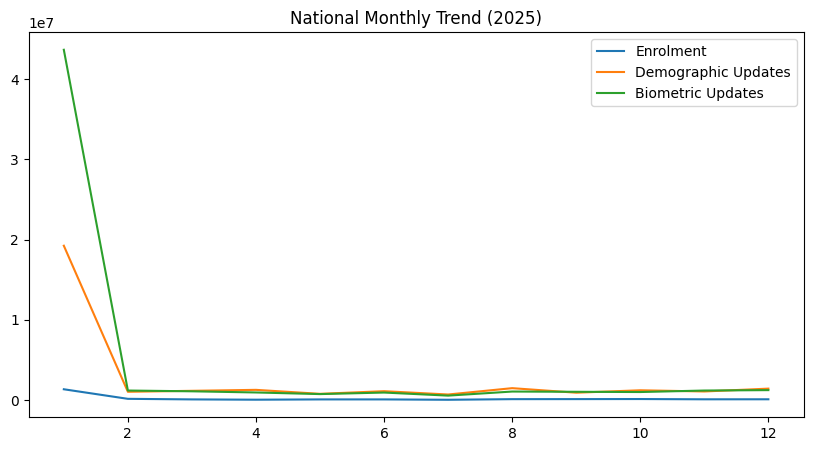

In [12]:
national_trend = state_month_df.groupby(['year','month'], as_index=False)[
    ['total_enrolment','total_demo_updates','total_bio_updates']
].sum()

plt.plot(national_trend['month'], national_trend['total_enrolment'], label='Enrolment')
plt.plot(national_trend['month'], national_trend['total_demo_updates'], label='Demographic Updates')
plt.plot(national_trend['month'], national_trend['total_bio_updates'], label='Biometric Updates')
plt.legend()
plt.title("National Monthly Trend (2025)")
plt.show()

1. High January Spike: Large Biometric and Demographic updates.
2. Very less new enrollments.

In [13]:
state_summary = (
    state_month_df
    .groupby('state', as_index=False)
    [['total_enrolment','total_bio_updates']]
    .sum()
    .sort_values('total_bio_updates', ascending=False)
)

state_summary.head(10)

,state,total_enrolment,total_bio_updates
41,Uttar Pradesh,554062,7398596
26,Maharashtra,171931,6844292
25,Madhya Pradesh,232136,5002187
5,Bihar,299950,3983240
38,Tamil Nadu,74155,3641395
36,Rajasthan,154860,3087599
2,Andhra Pradesh,41278,2908257
15,Gujarat,166816,2692985
21,Karnataka,96242,2107829
46,West Bengal,164549,1993487


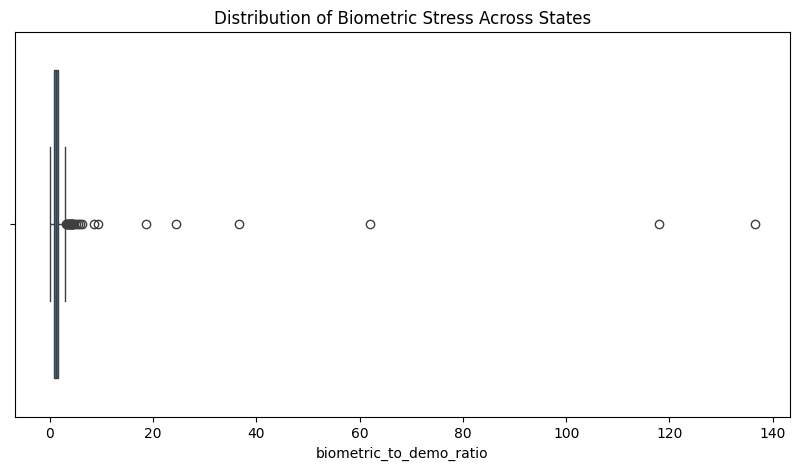

In [14]:
sns.boxplot(
    data=state_month_df,
    x='biometric_to_demo_ratio'
)
plt.title("Distribution of Biometric Stress Across States")
plt.show()

## Observations